# Libraries


In [1]:
%pip install lazypredict

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


# Loading Data


In [2]:
#load data

df= pd.read_csv('../data/salaries_data.csv')
df_test = pd.read_csv('../data/testeo.csv')

# Data Exploration

In [3]:
df= df.drop(['salary', 'salary_currency'], axis = 1)


In [8]:
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,SE,FT,Data Engineer,140250,US,100,US,M
1,2022,SE,FT,Data Engineer,135000,US,100,US,M
2,2021,MI,FT,BI Data Analyst,100000,US,100,US,M
3,2021,MI,CT,ML Engineer,270000,US,100,US,L
4,2021,MI,FT,Data Engineer,26005,RO,0,US,L


In [6]:
df_test.head()

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
0,2020,SE,FT,Machine Learning Scientist,JP,0,JP,S
1,2020,MI,FT,Lead Data Analyst,US,100,US,L
2,2020,MI,FT,Data Analyst,US,100,US,L
3,2020,MI,FT,Machine Learning Engineer,CN,0,CN,M
4,2020,MI,FT,Product Data Analyst,IN,100,IN,L


In [9]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
work_year,500.00,2021.41,0.68,2020.00,2021.00,2022.00,2022.00,2022.00
salary_in_usd,500.00,112996.22,69613.75,2859.00,64594.50,103080.00,150000.00,450000.00
remote_ratio,500.00,71.80,40.47,0.00,50.00,100.00,100.00,100.00


In [11]:
df.shape

(500, 9)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           500 non-null    int64 
 1   experience_level    500 non-null    object
 2   employment_type     500 non-null    object
 3   job_title           500 non-null    object
 4   salary_in_usd       500 non-null    int64 
 5   employee_residence  500 non-null    object
 6   remote_ratio        500 non-null    int64 
 7   company_location    500 non-null    object
 8   company_size        500 non-null    object
dtypes: int64(3), object(6)
memory usage: 35.3+ KB


In [13]:
df_s = df.groupby('job_title')['salary_in_usd'].mean()
df_s.sort_values()

job_title
3D Computer Vision Researcher                5409.00
Product Data Analyst                        20000.00
Computer Vision Engineer                    28226.75
Data Analytics Engineer                     35000.00
Machine Learning Infrastructure Engineer    54217.50
ETL Developer                               54957.00
Big Data Engineer                           57080.57
AI Scientist                                59410.60
Finance Data Analyst                        61896.00
Data Science Consultant                     67874.20
Computer Vision Software Engineer           70000.00
Machine Learning Developer                  78791.00
Head of Machine Learning                    79039.00
BI Data Analyst                             82454.40
Data Science Engineer                       83705.00
Lead Machine Learning Engineer              87932.00
Marketing Data Analyst                      88654.00
Business Data Analyst                       91253.50
Data Analyst                        

In [14]:
#Limits of Turkey's criterion to identify outliers.
Q1 = df['salary_in_usd'].quantile(0.25)
Q3 = df['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1

outliers = df.groupby('job_title')['salary_in_usd'].mean()[(df.groupby('job_title')['salary_in_usd'].mean() < Q1 - 1.5 * IQR) | (df.groupby('job_title')['salary_in_usd'].mean() > Q3 + 1.5 * IQR)]
outliers

job_title
Data Analytics Lead      405000.00
Financial Data Analyst   450000.00
Name: salary_in_usd, dtype: float64

In [15]:
#1.5 times the interquartile range rule.
Q11 = df['salary_in_usd'].quantile(0.25)
Q33 = df['salary_in_usd'].quantile(0.75)
IQRR = Q33 - Q11
upper_limit = Q33 + 1.5 * IQRR
lower_limit = Q33 - 1.5 * IQRR
print("Q11:", Q1)
print("Q33:", Q3)
print("IQRR:", IQRR)
print("Upper Limit for Outliers:", upper_limit)
print("Lower Limit for Outliers:", lower_limit)

Q11: 64594.5
Q33: 150000.0
IQRR: 85405.5
Upper Limit for Outliers: 278108.25
Lower Limit for Outliers: 21891.75


# Data division for train and predict

In [18]:
X = df[['salary_in_usd']]
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [19]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

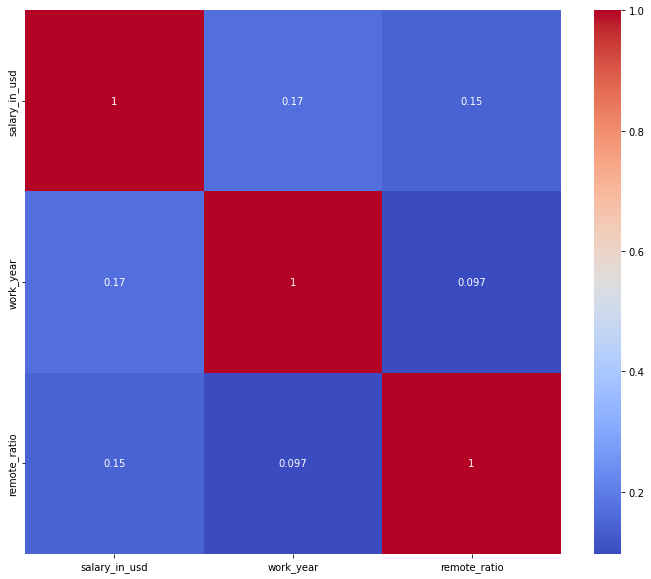

In [24]:
# Create a matrix of correlation for all the variables
corr_matrix = df.corr()

# Order
corr = corr_matrix['salary_in_usd'].sort_values(ascending=False)

# Create a heatmap woth the variables more correlated with salary
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix.loc[corr.index, corr.index], annot=True, cmap='coolwarm')
plt.show()

# Sort and rank data

#### Sort Experience level column according to salaries

In [20]:
df.groupby('experience_level')['salary_in_usd'].mean()

experience_level
EN    59989.57
EX   196078.85
MI    90384.61
SE   136341.79
Name: salary_in_usd, dtype: float64

## Sort for job title 

In [21]:
def job_title(x):
    if 'ml' in x.lower() or 'machine learning' in x.lower():
        return 'ml'
    elif 'analyst' in x.lower():
        return 'analyst'
    elif 'engineer' in x.lower():
        return 'engineer'
    elif 'scientist' in x.lower():
        return 'scientist'
    else:
        return 'other'
    
df['job_title'] = df['job_title'].apply(lambda x: job_title(x))
df_test['job_title'] = df_test['job_title'].apply(lambda x: job_title(x))



#### sort by job title and average salaries

In [25]:
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,SE,FT,engineer,140250,US,100,US,M
1,2022,SE,FT,engineer,135000,US,100,US,M
2,2021,MI,FT,analyst,100000,US,100,US,M
3,2021,MI,CT,ml,270000,US,100,US,L
4,2021,MI,FT,engineer,26005,RO,0,US,L


In [26]:
df = pd.get_dummies(df, columns = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size'])
df_test = pd.get_dummies(df_test, columns = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size'])


# Lazy Model

In [27]:
# Select the predictor variables and the target variable
X = df.drop(['salary_in_usd'], axis = 1)
y = df['salary_in_usd']


# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a linear regression model
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)


# Train the model with the training set
models, predictions = reg.fit(X_train, X_test, y_train, y_test)


print(models)

100%|██████████| 42/42 [00:05<00:00,  7.85it/s]

                                                            Adjusted R-Squared  \
Model                                                                            
Lars                          698168442509481163906183114995979575195860992.00   
RANSACRegressor                               55597888842277934003424067584.00   
TransformedTargetRegressor                     3175467926990929956649828352.00   
LinearRegression                               3175467926990929956649828352.00   
MLPRegressor                                                             37.64   
LinearSVR                                                                37.56   
KernelRidge                                                              35.31   
GaussianProcessRegressor                                                 14.75   
SVR                                                                      10.15   
QuantileRegressor                                                        10.14   
DummyRegressor  

In [28]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df.drop(['salary_in_usd'], axis = 1)
y = df['salary_in_usd']


mlp = MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X, y)



MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000)

In [29]:
X = df.drop(['salary_in_usd'], axis = 1)
y = df['salary_in_usd']

model3 = MLPRegressor()
model3.fit(X, y)

MLPRegressor()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


# Define the training and test data
X = df.drop(['salary_in_usd'], axis = 1)
y = df['salary_in_usd']


# Create the Gradient Boosting Regressor model
model3 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

# Train the model with the training data
model3.fit(X, y)



In [31]:
#let's create the missing columns in dftest with respect to df

def create_missing_columns(df, dftest):
    missing_cols = set(df.columns) - set(dftest.columns)
    for c in missing_cols:
        dftest[c] = 0
    dftest = dftest[df.columns]
    return dftest

df_test = create_missing_columns(df, df_test)
#elimino la columna salary_in_usd
df_test.drop(['salary_in_usd'], axis=1, inplace=True)

In [36]:
muestra3 = pd.read_csv('../data/muestra.csv')

In [38]:
muestra3['salary_in_usd'] = m3

In [39]:
m3 = model3.predict(df_test)

In [40]:
m3

array([62359.38005057, 65200.51651533, 65200.51651533, 62335.57558054,
       65155.64756751, 62280.92840489, 65193.17295363, 63773.07066175,
       65169.59323455, 65203.6555358 , 63739.66504981, 63794.39242707,
       65188.51444804, 63717.82824658, 65142.10521288, 63771.66453705,
       65226.10318675, 65231.14875838, 65215.823184  , 65224.43579629,
       63794.89990611, 63812.67837442, 65225.44578761, 65234.62691344,
       65178.34657455, 63753.78863481, 62403.25589829, 62414.34773538,
       65189.02412917, 63777.0615675 , 62366.42136158, 65226.16709536,
       65210.49444144, 63797.70141078, 63756.79651723, 63807.15413166,
       65234.49529116, 62359.7867844 , 63807.05947218, 65234.43898173,
       63747.13715453, 65181.29814754, 65231.29996127, 65236.00401064,
       65224.91217355, 65232.55256707, 62409.68041482, 63807.19109446,
       65226.16709536, 65204.9046078 , 63816.90398663, 63776.46296737,
       62442.02888966, 65262.12013602, 62440.61506365, 62432.67041154,
      

In [41]:
muestra3.head()

,id,salary_in_usd
0,0,62359.38
1,1,65200.52
2,2,65200.52
3,3,62335.58
4,4,65155.65


In [ ]:
muestra3.to_csv('competition4.csv', index = False)